In [1046]:
# Importando as bibliotecas que serão utilizadas

import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras.backend as K
from tensorflow import keras
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.metrics import fbeta_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings('ignore',category=Warning)

In [1047]:
df = pd.read_csv(os.getcwd()+f'//df_white_final.csv')

In [1048]:
# Separando x e y

target = 'opinion'
x = df.drop(columns=[target])
y = df[[target]]

In [1049]:
# Analisando as colunas da variável x

x

,Unnamed: 0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8
1,1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5
2,2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1
3,3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9
4,4,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.99490,3.18,0.47,9.6
...,...,...,...,...,...,...,...,...,...,...,...,...
3826,3937,5.7,0.21,0.32,0.9,0.038,38.0,121.0,0.99074,3.24,0.46,10.6
3827,3938,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2
3828,3939,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6
3829,3940,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8


In [1050]:
# Vou 'dropar' a coluna 'Unnamed: 0'

x.drop(columns='Unnamed: 0',inplace=True)

In [1051]:
# Separando conjuntos de treino, validação e teste

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=10)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train,random_state=10)

In [1052]:
# Verificando as proporções de classes

proportions = pd.DataFrame(df[target].value_counts(normalize=True).values,
                     index=df[target].value_counts(normalize=True).index,
                     columns=['original'])
proportions['treino'] = y_train[target].value_counts(normalize=True).values
proportions['validação'] = y_val[target].value_counts(normalize=True).values
proportions['teste'] = y_test[target].value_counts(normalize=True).values
proportions

,original,treino,validação,teste
opinion,,,,
1,0.6651,0.665035,0.665579,0.664928
0,0.3349,0.334965,0.334421,0.335072


In [1053]:
# Normalizando os dados

scaler = MinMaxScaler(feature_range=(0,1))

# Treinando o scaler na base de treino

scaler.fit(x_train)

# Aplicando em todas as bases

x_train_norm = scaler.transform(x_train)
x_val_norm = scaler.transform(x_val)
x_test_norm = scaler.transform(x_test)

In [1054]:
# Função para criar o modelo

def create_ann_model(x, n_neurons: list):
  """
  Cria a rede neural com base nos parâmetros informados.
  """
  # Definir o modelo
  model = Sequential()
  if len(n_neurons) == 1:
    model.add(Dense(n_neurons[0], input_shape=(11,), activation='relu'))
  else:
    for n in n_neurons:
      if n == n_neurons[0]:
        model.add(Dense(n, input_shape=(11,), activation='relu'))
      else:
        model.add(Dense(n, activation='relu'))

  # Camada de saída - função de ativação sigmoidal
        
  model.add(Dense(1, activation='sigmoid'))

  return model


## Serão implementados 3 modelos variando a quantidade de neurônios somente na camada de entrada, a saída permenecerá com 1 neurônio.

```Modelo 1: 11 neurônios```

In [1055]:
# Criando e testando o primeiro modelo

model_1 = create_ann_model(x_train_norm, n_neurons=[11])
model_1.summary()

Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_156 (Dense)           (None, 11)                132       
                                                                 
 dense_157 (Dense)           (None, 1)                 12        
                                                                 
Total params: 144 (576.00 Byte)
Trainable params: 144 (576.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [1057]:
# Função para calcular a f-beta-score

def fbeta(y_train, y_val):
    beta=0.001
    y_val = K.clip(y_val, 0, 1)

    tp = K.sum(K.round(K.clip(y_train * y_val, 0, 1)), axis=1)
    fp = K.sum(K.round(K.clip(y_val - y_train, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_train - y_val, 0, 1)), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    num = (1 + beta ** 2) * (p * r)
    den = (beta ** 2 * p + r + K.epsilon())
    return K.mean(num / den)

In [1059]:
# Compilar o modelo com F1-score como métrica

model_1.compile(loss='binary_crossentropy', optimizer='sgd', metrics=fbeta)

In [1060]:
# Treinando o primeiro modelo

print("Treinamento em andamento...")

history_1 = model_1.fit(x_train_norm, y_train, epochs=120, batch_size=60, validation_data=(x_val_norm, y_val), verbose=0)

print("Treinamento concluído!")


Treinamento em andamento...


Treinamento concluído!


In [1061]:
def plot_history(history, n_epochs):

    # Obtendo as métricas do histórico
    
    train_f1 = history.history['fbeta']
    val_f1 = history.history['val_fbeta']
    train_f1_loss = history.history['loss']
    val_f1_loss = history.history['val_loss']

    # Plotando o gráfico de F1-score

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    plt.plot(range(1,n_epochs+1), train_f1, label='Treino')
    plt.plot(range(1,n_epochs+1), val_f1, label='Validação')
    plt.legend(loc='best')
    plt.title('F1-score ao longo das épocas')
    plt.xlabel('Épocas')
    plt.ylabel('F1-score')

     # Plotando o gráfico da função de perda
    
    ax = fig.add_subplot(1, 2, 2)
    plt.plot(range(1, n_epochs+1), train_f1_loss, label='Treino')
    plt.plot(range(1, n_epochs+1), val_f1_loss, label='Validação')
    plt.legend(loc='best')
    plt.title('Função de perda ao longo das épocas')
    plt.xlabel('Épocas')
    plt.ylabel('Função de perda')
    plt.show()

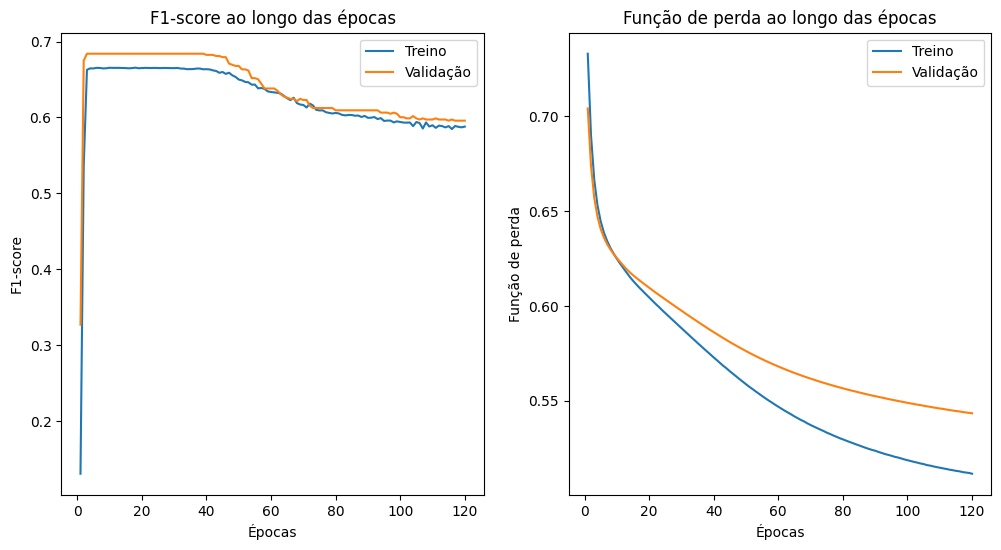

In [1062]:
plot_history(history_1, 120)

```Modelo 2: 22 neurônios```

In [1063]:
# Criando e testando o segundo modelo

model_2 = create_ann_model(x_train_norm, n_neurons=[22])
model_2.summary()

Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_158 (Dense)           (None, 22)                264       
                                                                 
 dense_159 (Dense)           (None, 1)                 23        
                                                                 
Total params: 287 (1.12 KB)
Trainable params: 287 (1.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [1065]:
# Compilar o modelo com F1-score como métrica

model_2.compile(loss='binary_crossentropy', optimizer='sgd', metrics=fbeta)

In [1066]:
# Treinando o segundo modelo

print("Treinamento em andamento...")

history_2 = model_2.fit(x_train_norm, y_train, epochs=120, batch_size=60, validation_data=(x_val_norm, y_val), verbose=0)

print("Treinamento concluído!")

Treinamento em andamento...
Treinamento concluído!


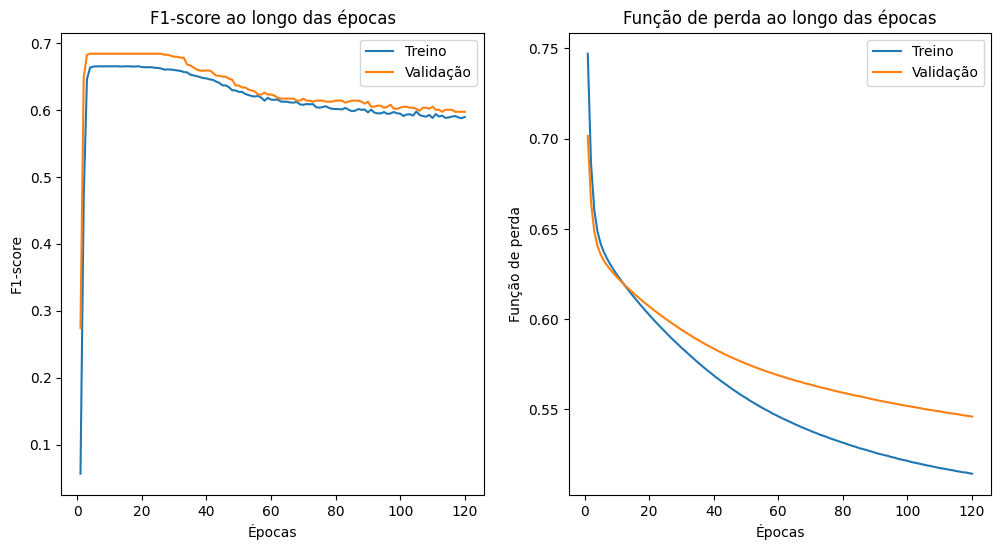

In [1067]:
plot_history(history_2, 120)

```Modelo 3: 33 neurônios```

In [1068]:
# Criando e testando o terceiro modelo

model_3 = create_ann_model(x_train_norm, n_neurons=[33])
model_3.summary()

Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_160 (Dense)           (None, 33)                396       
                                                                 
 dense_161 (Dense)           (None, 1)                 34        
                                                                 
Total params: 430 (1.68 KB)
Trainable params: 430 (1.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [1070]:
# Compilar o modelo com F1-score como métrica

model_3.compile(loss='binary_crossentropy', optimizer='sgd', metrics=fbeta)

In [1071]:
# Treinando o terceiro modelo

print("Treinamento em andamento...")

history_3 = model_3.fit(x_train_norm, y_train, epochs=120, batch_size=60, validation_data=(x_val_norm, y_val), verbose=0)

print("Treinamento concluído!")

Treinamento em andamento...


Treinamento concluído!


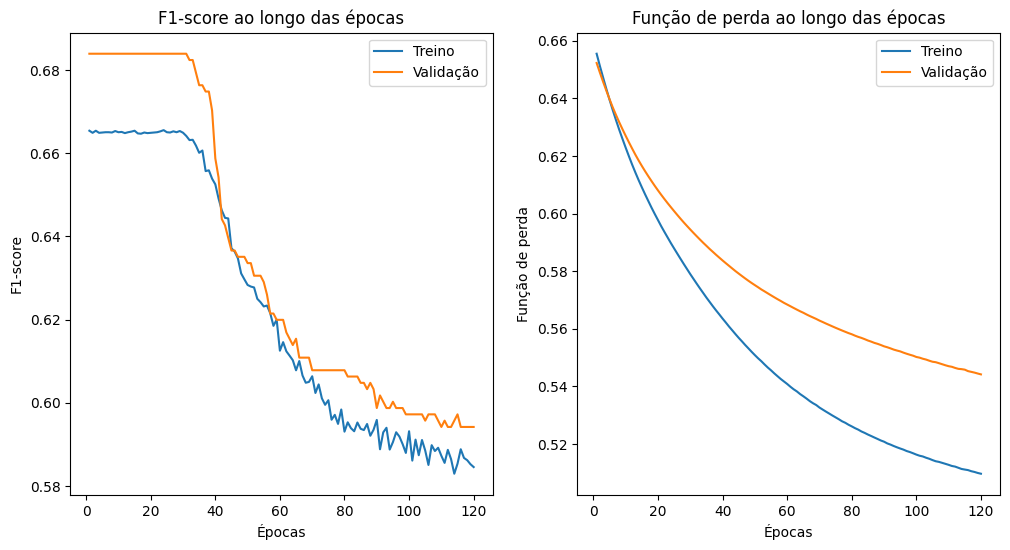

In [1072]:
plot_history(history_3, 120)

In [1073]:
# Função de análise de resultados

def analyze_results(x_test_norm, list_models, list_model_names, THRESHOLD=0.6):
  for i in range(len(list_models)):

    # Faz a previsão na base de teste

    yhat_test = list_models[i].predict(x_test_norm)

    # Transforma em classes

    yhat_test_class = [1 if x >= THRESHOLD else 0 for x in yhat_test]

    # Imprime resultados
    
    print(f'DESEMPENHO DE CLASSIFICAÇÃO - MODELO {i+1} - {list_model_names[i]} - Prob. min = {THRESHOLD}')
    # print(classification_report(y_test, yhat_test_class))
    print(fbeta_score(y_test, yhat_test_class, beta=0.001))
   
    print('*' * 50)
    print('\n')

In [1074]:
# Definindo lista de modelos e de nomes

list_models = [model_1, model_2, model_3]
list_model_names = ['11 neurônios', '22 neurônios', '33 neurônios']
analyze_results(x_test_norm, list_models, list_model_names)

24/24 [==============================] - 0s 6ms/step
DESEMPENHO DE CLASSIFICAÇÃO - MODELO 1 - 11 neurônios - Prob. min = 0.6
0.8323232071013421
**************************************************


24/24 [==============================] - 0s 3ms/step
DESEMPENHO DE CLASSIFICAÇÃO - MODELO 2 - 22 neurônios - Prob. min = 0.6
0.8273092170126491
**************************************************


24/24 [==============================] - 0s 2ms/step
DESEMPENHO DE CLASSIFICAÇÃO - MODELO 3 - 33 neurônios - Prob. min = 0.6
0.8289738213749519
**************************************************




In [1075]:
y_pred = model_1.predict(x_test_norm)

y_class = [1 if x >= 0.6 else 0 for x in y_pred]

12/24 [==============>...............] - ETA: 0s

24/24 [==============================] - 0s 5ms/step


Text(0.5, 1.0, 'Matriz de Confusão')

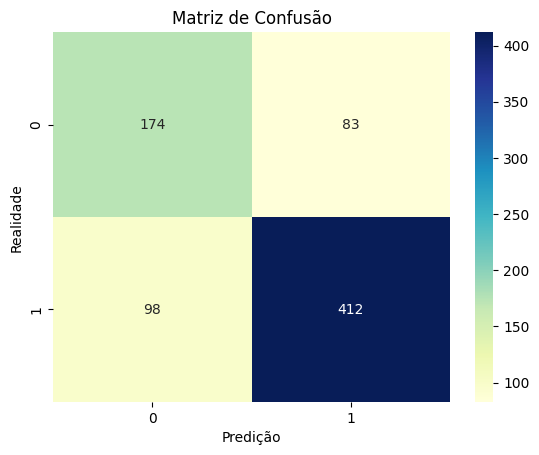

In [1076]:
conf_matrix_red = confusion_matrix(y_test, y_class)
ax = sns.heatmap(conf_matrix_red, cmap='YlGnBu', annot=True, fmt='g')
ax.set_xlabel('Predição')
ax.set_ylabel('Realidade')
ax.set_title('Matriz de Confusão')

In [1077]:
precision = np.diag(conf_matrix_red) / np.sum(conf_matrix_red, axis=0)
recall = np.diag(conf_matrix_red) / np.sum(conf_matrix_red, axis=1)
beta = 0.001
f_beta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

print(' ' * 7, '*'*15)
print(' ' * 8, "F-BETA SCORES")
print(' ' * 7, '*'*15)
print('\n') 
for i in range(len(f_beta)):
    print(f"Classe {i}: {f_beta[i]}")


        ***************
         F-BETA SCORES
        ***************


Classe 0: 0.6397059176308056
Classe 1: 0.8323232071013421


In [1078]:
yhat_hist_train = model_1.predict(x_train_norm)

77/77 [==============================] - 0s 2ms/step


In [1079]:
yhat_hist_test = model_1.predict(x_test_norm)

24/24 [==============================] - 0s 5ms/step


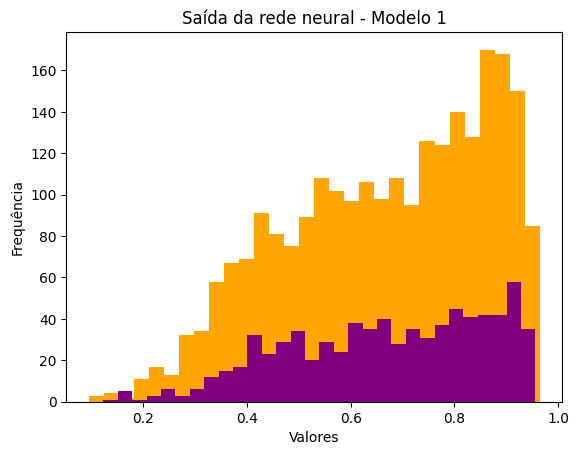

In [1080]:
plt.title('Saída da rede neural - Modelo 1')
plt.hist(yhat_hist_train, bins=30, color='orange', label='treino')
plt.hist(yhat_hist_test, bins=30, color='purple', label='test')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.show()